In [1]:
import faiss # make faiss available
import numpy as np
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_paths=[]
with open("../geological_map.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

embedding = np.load("../geological_embed.npy")

29998


In [3]:
random_img_index=random.randint(0, len(image_paths)-1)
xq=embedding[random_img_index]
xb=embedding
print(xb.shape)
print(xq.shape)
xq=np.reshape(xq, (1, 576))
print(xq.shape)

(29998, 576)
(576,)
(1, 576)


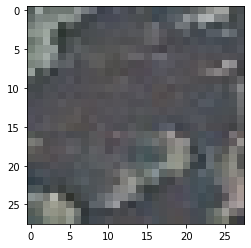

In [4]:
input_image_path=image_paths[random_img_index]
input_img = Image.open("../"+input_image_path).convert("RGB")
plt.imshow(input_img)
plt.show()

In [5]:
index = faiss.IndexFlatL2(576)# build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)
k=10
Dist, Indices = index.search(xq, k)     # actual search
print(Indices)                   # neighbors of the 5 first queries


True
29998
[[21399 22679 22413 22774 20838 22228 24329 21344 22672 23719]]


total indices:  10
geological_similarity\rhyolite\9W4QT.jpg


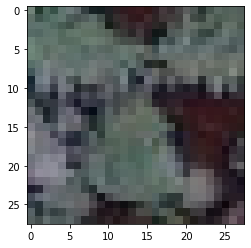

geological_similarity\rhyolite\J56HK.jpg


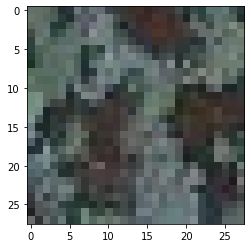

geological_similarity\rhyolite\HAI02.jpg


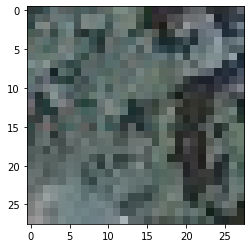

geological_similarity\rhyolite\JUGUB.jpg


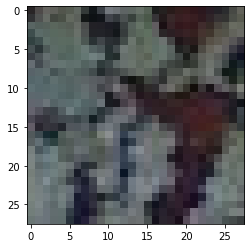

geological_similarity\rhyolite\5WP7H.jpg


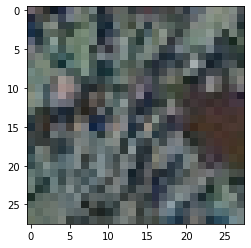

geological_similarity\rhyolite\FYCDJ.jpg


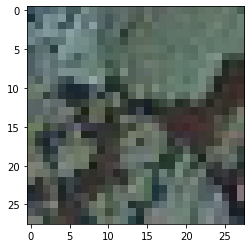

geological_similarity\rhyolite\V3ZB3.jpg


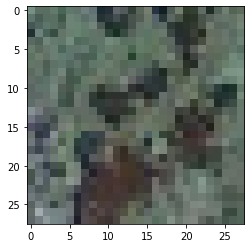

geological_similarity\rhyolite\9IZLF.jpg


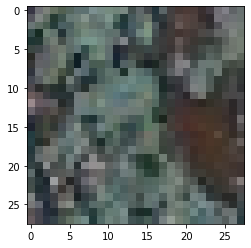

geological_similarity\rhyolite\J4CKF.jpg


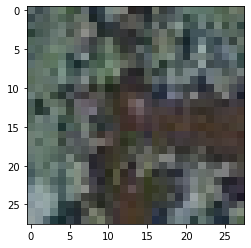

geological_similarity\rhyolite\QHANA.jpg


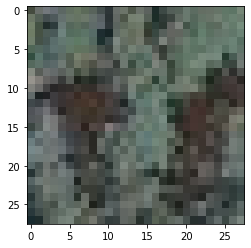

In [6]:
indices = Indices[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [ ]:
index = faiss.IndexFlatL2(576)# build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)
k=10
Dist, Indices = index.search(xq, k)     # actual search
print(Indices)                   # neighbors of the 5 first queries

In [15]:
#IVF-L2
import time
nlist = 100
k = 10
quantizer = faiss.IndexFlatL2(576)  # the other index
index = faiss.IndexIVFFlat(quantizer, 576, nlist, faiss.METRIC_L2)
# here we specify METRIC_L2, by default it performs inner-product search

assert not index.is_trained
index.train(xb)
assert index.is_trained

index.add(xb)                  # add may be a bit slower as well

start=time.time()
D, I = index.search(xq, k)     # actual search
# print(I[-5:])# neighbors of the 5 last queries
end=time.time()
print(end-start)
index.nprobe = 10 # default nprobe is 1, try a few more
start=time.time()
D, I = index.search(xq, k)
end=time.time()
print(end-start)
print(I)                  # neighbors of the 5 last queries

0.0019998550415039062
0.00299835205078125
[[23120 23551 22678 21582 21669  2101 22349 24003  4716 23902]]


total indices:  10
geological_similarity\rhyolite\M24QG.jpg


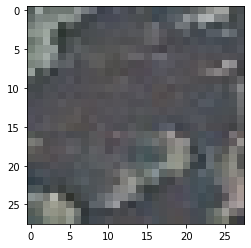

geological_similarity\rhyolite\P39YI.jpg


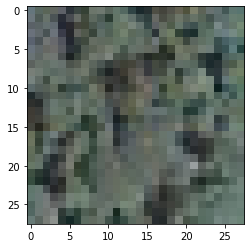

geological_similarity\rhyolite\J52R4.jpg


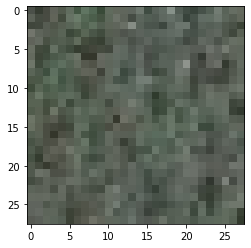

geological_similarity\rhyolite\BB35N.jpg


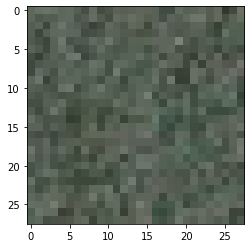

geological_similarity\rhyolite\BW6AD.jpg


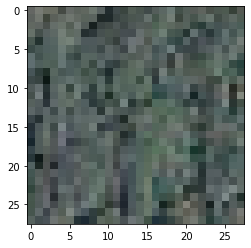

geological_similarity\andesite\EWL6T.jpg


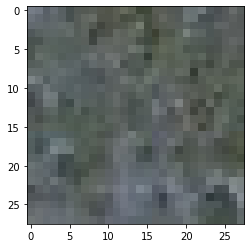

geological_similarity\rhyolite\GOUKF.jpg


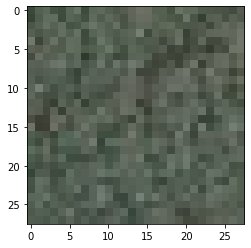

geological_similarity\rhyolite\SMALN.jpg


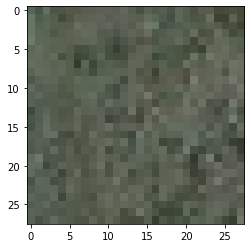

geological_similarity\andesite\XSZDF.jpg


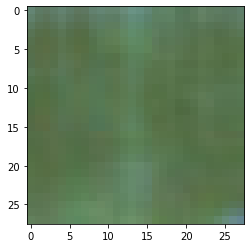

geological_similarity\rhyolite\RU90W.jpg


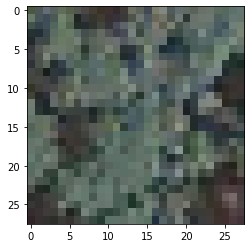

In [10]:
indices = I[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [13]:
#IVF Cosine

import faiss

nlist = 100
m = 8
k = 10
quantizer = faiss.IndexFlatL2(576)  # this remains the same
index = faiss.IndexIVFPQ(quantizer, 576, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
index.train(xb)
index.add(xb)
index.nprobe = 10              # make comparable with experiment above
D, I = index.search(xq, k)     # search
print(I[-5:])

[[23120 23551 21669 21582 24280 20424 22678 21972  1102 23247]]


total indices:  10
geological_similarity\rhyolite\M24QG.jpg


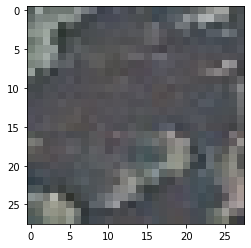

geological_similarity\rhyolite\P39YI.jpg


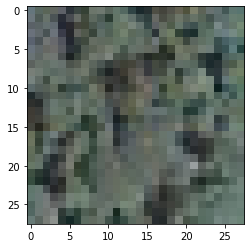

geological_similarity\rhyolite\BW6AD.jpg


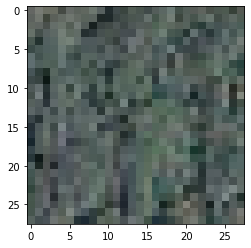

geological_similarity\rhyolite\BB35N.jpg


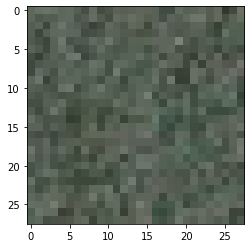

geological_similarity\rhyolite\UTM4G.jpg


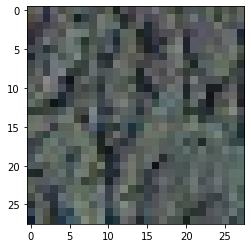

geological_similarity\rhyolite\2XWKV.jpg


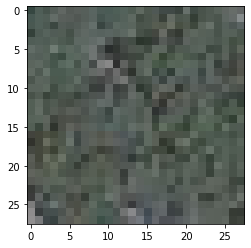

geological_similarity\rhyolite\J52R4.jpg


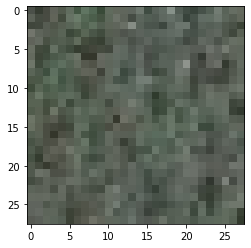

geological_similarity\rhyolite\E1YTE.jpg


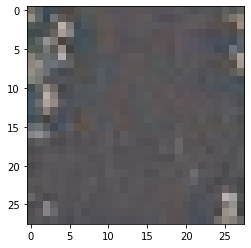

geological_similarity\andesite\81UIC.jpg


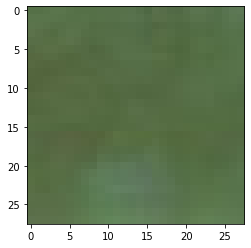

geological_similarity\rhyolite\MWNU8.jpg


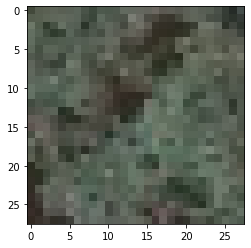

In [14]:
indices = I[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()